# Semantic Segmentation

### Required Header files

In [1]:
import numpy as np
import pandas as pd
import imageio
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### Loading the images

In [2]:
image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [3]:
def list_image_paths(directory_path):
    image_paths = []
    for directory in range(len(directory_path)):
        image_filenames = os.listdir(directory_path[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_path[directory] + image_filename)
    return image_paths

In [4]:
image_paths = list_image_paths(image_path) 
mask_paths = list_image_paths(mask_path)

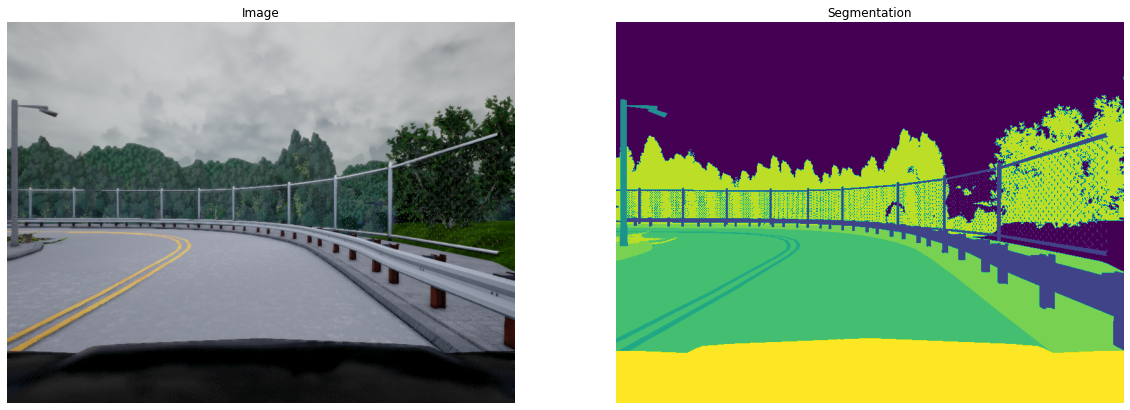

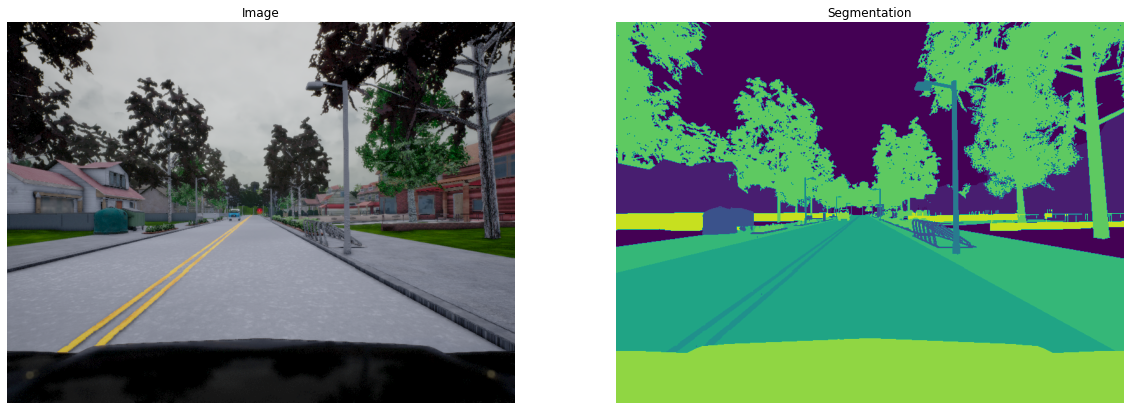

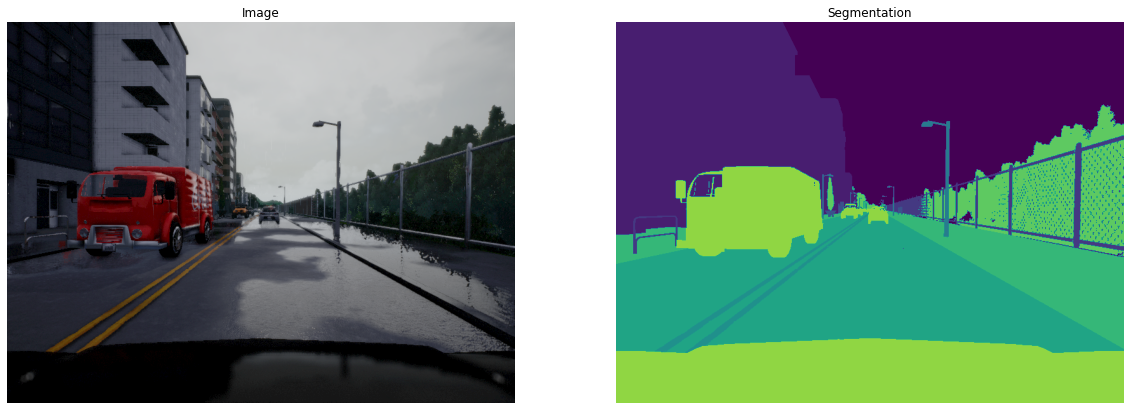

In [5]:
for i in range(3):
    img = imageio.imread(image_paths[i])
    mask = imageio.imread(mask_paths[i])
    mask = np.array([mask[i, j][0] for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
    fig, arr = plt.subplots(1, 2, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    


### Train test split

In [6]:
train_image_paths,val_image_paths,train_mask_paths,val_mask_paths = train_test_split(image_paths, mask_paths,train_size=0.8)
validation_image_paths,test_image_paths,validation_mask_paths,test_mask_paths = train_test_split(val_image_paths,val_mask_paths,train_size = 0.8)

In [7]:
def read_image(image_path, mask_path):   
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    return image, mask

In [8]:
def data_prefetch(image_paths, mask_paths, buffer_size, batch_size): 
    image_list = tf.constant(image_paths) 
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)
    return dataset

In [9]:
batch_size = 32
buffer_size = 500
train_dataset = data_prefetch(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_prefetch(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_prefetch(test_image_paths, test_mask_paths, buffer_size, batch_size)

## U-Net Architecture

In [10]:
def encoding_block(inputs, filters, dropout_prob=0.6, max_pooling=True):
    """
    Convolutional encoding/downsampling block
    Arguments:
        inputs -- Input tensor
        filters -- Number of filters for the convolutional layers
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection inputs 
    """
    C = Conv2D(filters,3,padding="same",kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    C = Conv2D(filters,3,padding="same",kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    skip_connection = C
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)        
    else:
        next_layer = C
    return next_layer, skip_connection

In [11]:
def decoding_block(inputs, skip_connection_input, filters):
    """
    Convolutional decoding/upsampling block
    Arguments:
        inputs -- Input tensor from previous layer
        skip_connection_input -- Input tensor from previous skip layer
        filters -- Number of filters for the convolutional layers
    Returns: 
        C -- Tensor output
    """
    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    residual_connection = concatenate([CT, skip_connection_input], axis=3)
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    return C

In [12]:
def unet_model(input_size, filters, n_classes):
    """
    Unet model
    Arguments:
        input_size -- Input shape
        filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    D1,C1 = encoding_block(inputs,filters,max_pooling=True)
    D2,C2 = encoding_block(D1,filters*2,max_pooling=True)
    D3,C3 = encoding_block(D2,filters*4,max_pooling=True)
    D4,C4 = encoding_block(D3,filters*8,max_pooling=True)
    D5,C5 = encoding_block(D4,filters*16,max_pooling=False)
    # Expanding Path (decoding)
    U6 = decoding_block(D5,C4,filters*8)
    U7 = decoding_block(U6,C3,filters*4)
    U8 = decoding_block(U7,C2,filters=filters*2)
    U9 = decoding_block(U8,C1,filters=filters)
    C10 = Conv2D(filters,3,activation='relu',padding='same',kernel_initializer='he_normal')(U9)
    C11 = Conv2D(filters = n_classes, kernel_size = (1,1), activation='sigmoid', padding='same')(C10)
    model = Model(inputs=inputs, outputs=C11)
    return model

In [13]:
img_height = 256
img_width = 256
num_channels = 3
model = unet_model((img_height, img_width, num_channels), filters=32, n_classes=23)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 32
epochs = 30

In [15]:
history = model.fit(train_dataset, 
                    validation_data = validation_dataset, 
                    epochs = epochs, 
                    verbose=1, 
                    callbacks = [callback, reduce_lr], 
                    batch_size = batch_size, 
                    shuffle = True)

Epoch 1/30
125/125 [==============================] - 198s 1s/step - loss: 0.6126 - accuracy: 0.8399 - val_loss: 3.2841 - val_accuracy: 0.5965
Epoch 2/30
125/125 [==============================] - 52s 420ms/step - loss: 0.2080 - accuracy: 0.9367 - val_loss: 1.5586 - val_accuracy: 0.7193
Epoch 3/30
125/125 [==============================] - 52s 420ms/step - loss: 0.1589 - accuracy: 0.9501 - val_loss: 0.8403 - val_accuracy: 0.8219
Epoch 4/30
125/125 [==============================] - 52s 419ms/step - loss: 0.1269 - accuracy: 0.9595 - val_loss: 0.1803 - val_accuracy: 0.9433
Epoch 5/30
125/125 [==============================] - 52s 419ms/step - loss: 0.1228 - accuracy: 0.9606 - val_loss: 0.1196 - val_accuracy: 0.9610
Epoch 6/30
125/125 [==============================] - 52s 419ms/step - loss: 0.0983 - accuracy: 0.9678 - val_loss: 0.1020 - val_accuracy: 0.9666
Epoch 7/30
125/125 [==============================] - 53s 422ms/step - loss: 0.0923 - accuracy: 0.9694 - val_loss: 0.0875 - val_accu

In [16]:
model.save('u-net-segmentation.h5')

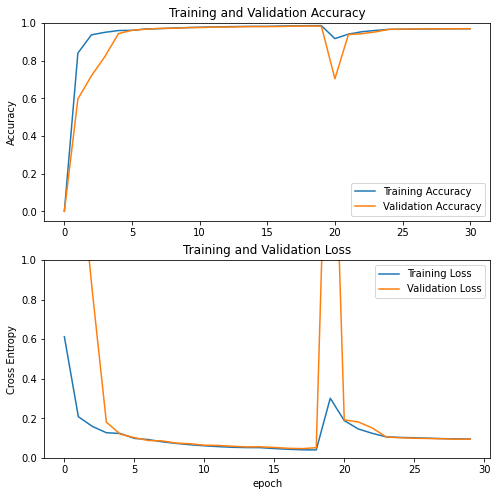

In [17]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

7/7 [==============================] - 7s 210ms/step - loss: 0.0937 - accuracy: 0.9692


In [19]:
print('Training accuracy is',train_accuracy)
print('Validation accuracy is',validation_accuracy)
print('Testing accuracy is',test_accuracy)

Training accuracy is 0.9696956872940063
Validation accuracy is 0.9693496823310852
Testing accuracy is 0.9691940546035767


In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]

In [21]:
def display(display_list):
    plt.figure(figsize=(18, 18))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [22]:
def show_predictions(dataset, num):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

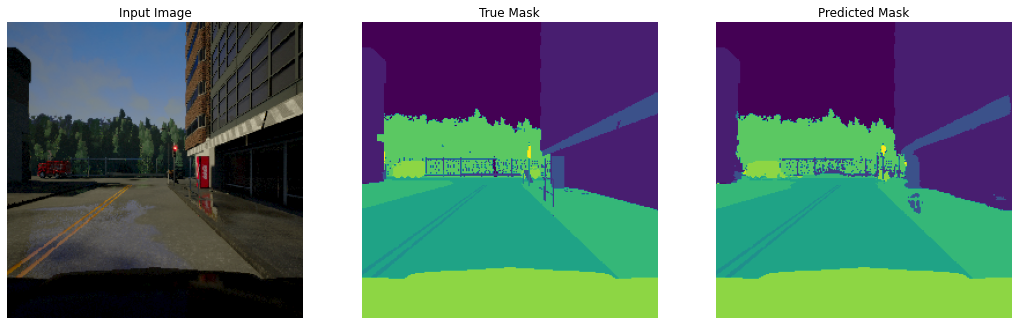

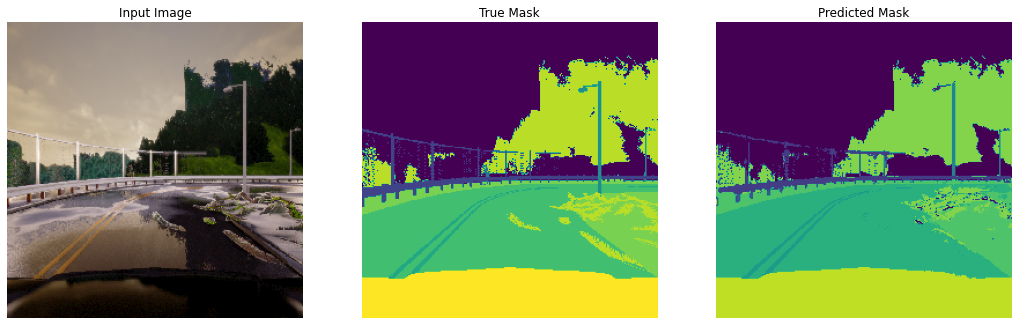

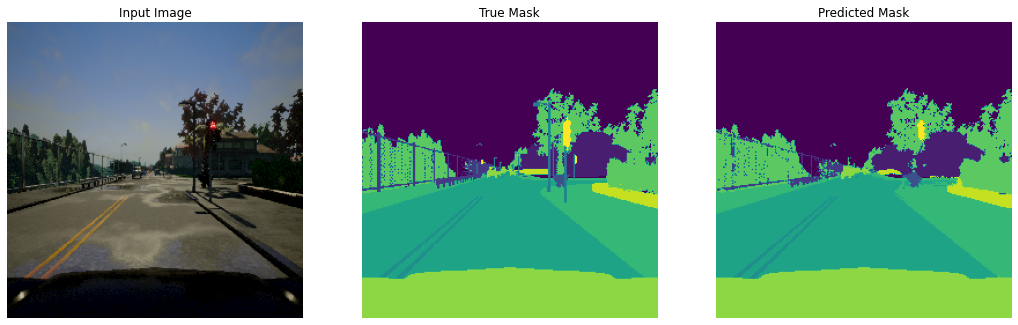

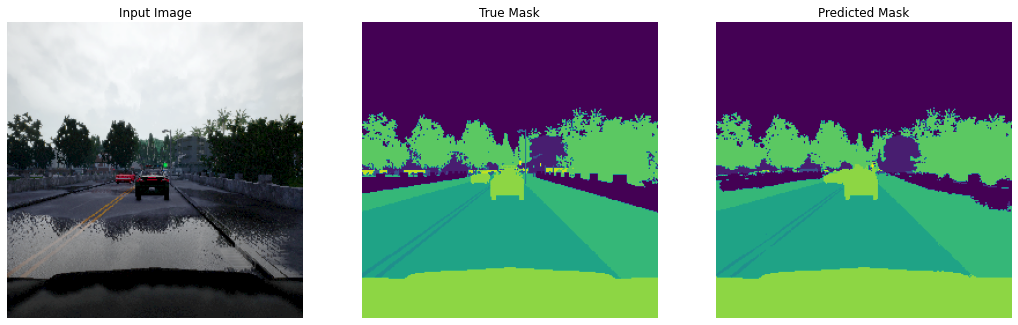

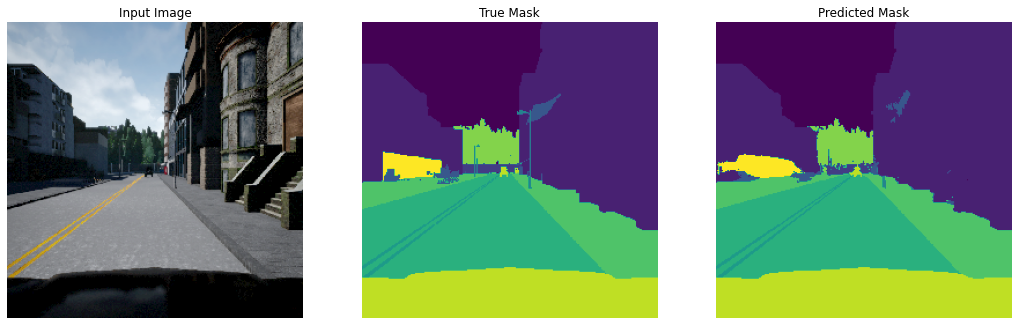

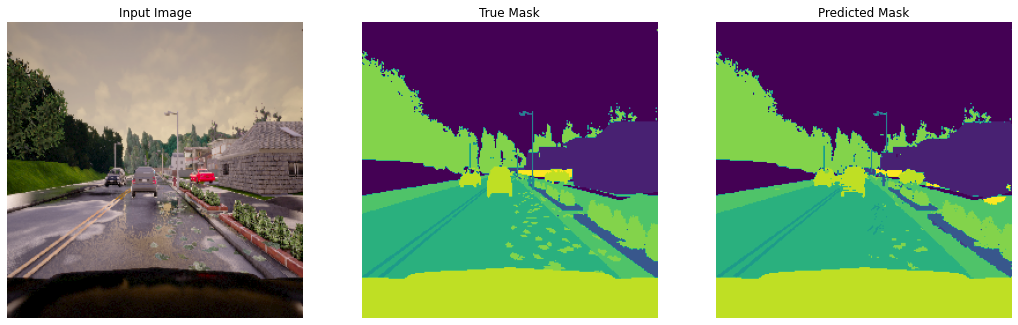

In [23]:
show_predictions(train_dataset, 6)

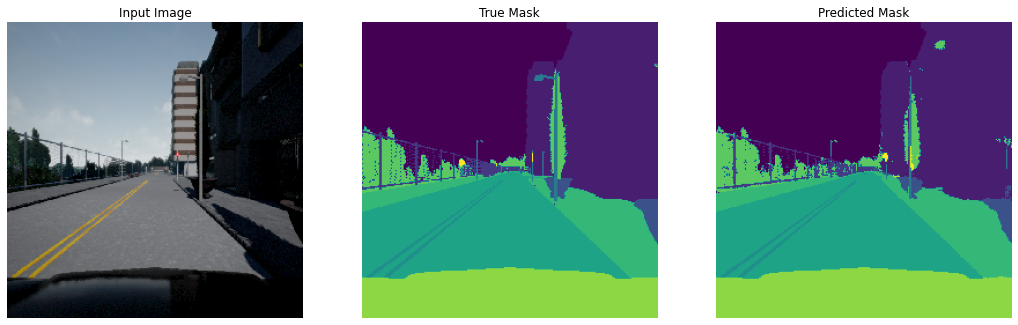

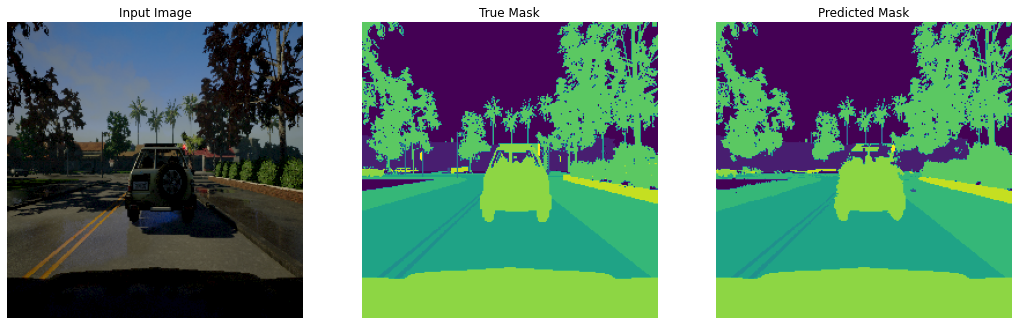

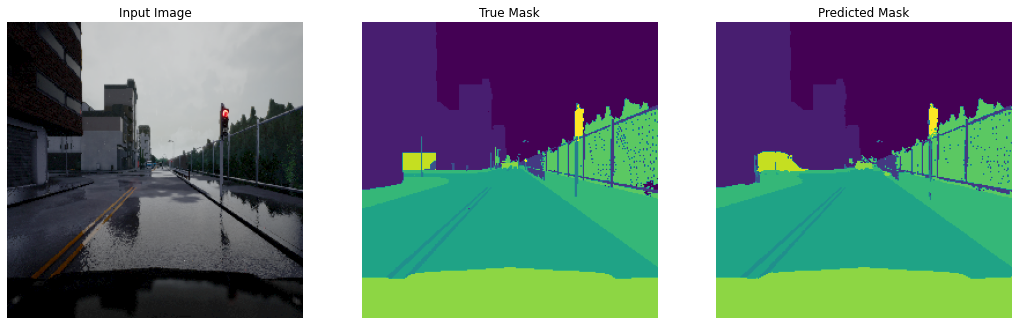

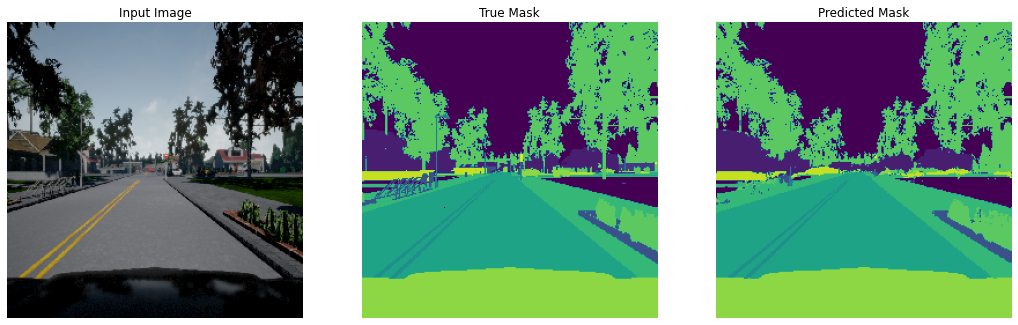

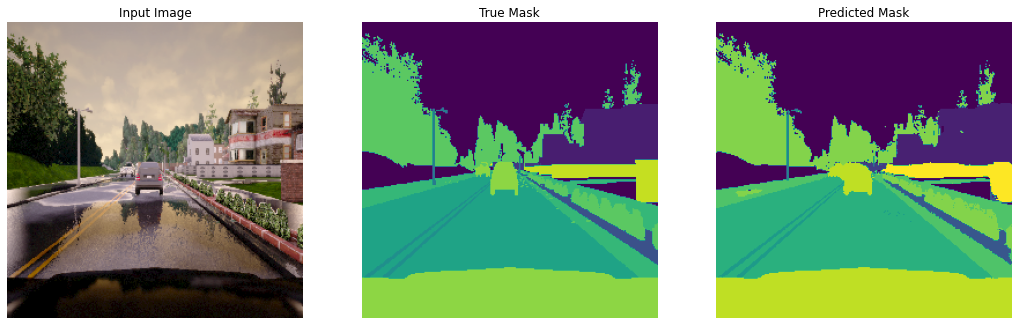

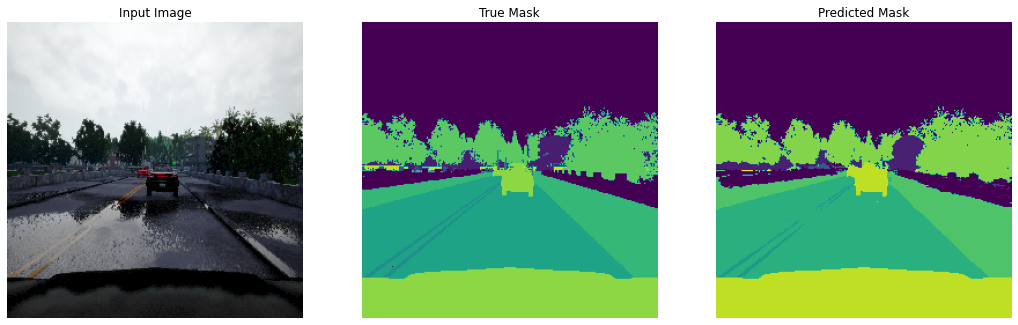

In [24]:
show_predictions(test_dataset, 6)